# Temporal Community Structure Experiments

In [1]:
# Uncomment below lines and run this cell to install neuronav and requirements for colab.

#!git clone https://github.com/awjuliani/neuro-nav
#!pip install ./neuro-nav[experiments_remote]

### Imports and helper functions

In [2]:
from neuronav.envs.graph_env import GraphEnv, GraphObsType
from neuronav.agents.td_agents import TDSR
from neuronav.envs.graph_structures import GraphStructure
from neuronav.utils import run_episode
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch
import torch.nn as nn

In [3]:
def build_color_list(items):
    color_list = []
    for item in items:
        if item < 5:
            color_list.append("red")
        elif item < 10:
            color_list.append("blue")
        else:
            color_list.append("green")
    return color_list


def plot_projection(values, colors):
    plt.scatter(values[:, 0], values[:, 1], c=colors, s=200, alpha=0.75)

### The neighborhood graph environment

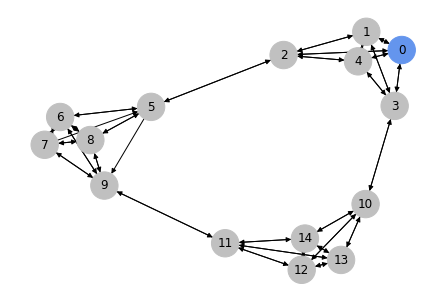

In [4]:
env = GraphEnv(
    graph_structure=GraphStructure.neighborhood, obs_type=GraphObsType.onehot
)
obs = env.reset(goal_pos=[0 for i in range(15)])
env.render()

pca = PCA(2)

### Plotting observation space projection

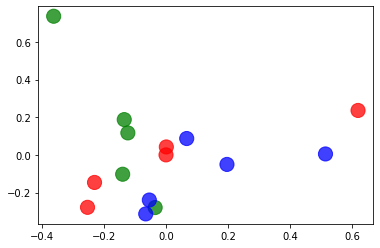

In [5]:
all_obs = {}

obs = env.reset(goal_pos=[0 for i in range(15)])
idx = np.argmax(obs)
all_obs[idx] = obs
for i in range(200):
    next_obs, _, _, _ = env.step(env.action_space.sample())
    obs = next_obs
    idx = np.argmax(obs)
    if idx not in all_obs.keys():
        all_obs[idx] = obs

colors_r = build_color_list(all_obs)
vals = np.stack(list(all_obs.values()))
result = pca.fit_transform(vals)
plot_projection(result, colors_r)

### Plotting predictive model projection

In [6]:
class Predictor(nn.Module):
    def __init__(self, obs_size, h_size):
        super(Predictor, self).__init__()
        self.encoder = nn.Linear(obs_size, h_size)
        self.decoder = nn.Linear(h_size, obs_size)
        self.optim = torch.optim.Adam(self.parameters(), 5e-4)

    def forward(self, x):
        z = torch.tanh(self.encoder(x))
        pred_x = self.decoder(z)
        return pred_x, z

In [7]:
def collect_pairs():
    xs = []
    ys = []
    ds = []

    obs = env.reset(goal_pos=[0 for i in range(15)])
    for j in range(100):
        next_obs, _, _, _ = env.step(env.action_space.sample())
        xs.append(obs)
        ys.append(next_obs)
        ds.append(np.argmax(obs))
        obs = next_obs
    xs = torch.tensor(np.stack(xs))
    ys = torch.tensor(np.stack(ys))

    return xs, ys, ds

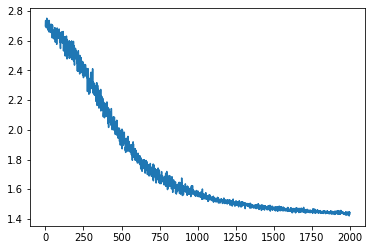

In [8]:
env = GraphEnv(
    graph_structure=GraphStructure.neighborhood, obs_type=GraphObsType.onehot
)
predictor = Predictor(env.state_size, 32)

losses = []
for i in range(2000):
    predictor.optim.zero_grad()
    xs, ys, ds = collect_pairs()
    pred_ys, zs = predictor(xs)
    loss = torch.nn.functional.cross_entropy(pred_ys, ys)
    losses.append(loss.item())
    loss.backward()
    predictor.optim.step()
plt.plot(losses)

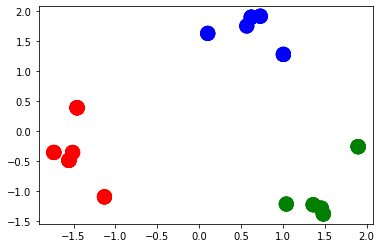

In [9]:
colors_z = build_color_list(ds)
zs = zs.detach()
result_z = pca.fit_transform(zs)
plot_projection(result_z, colors_z)

### Plotting successor representation projection

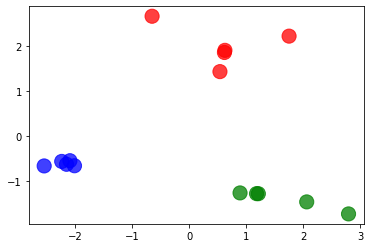

In [10]:
env = GraphEnv(graph_structure=GraphStructure.neighborhood, obs_type=GraphObsType.index)
agent = TDSR(env.state_size, env.action_space.n)

for i in range(20):
    agent, _ = run_episode(env, agent, goal_pos=[0 for i in range(15)], max_steps=200)

M = np.mean(agent.M, axis=0)
result_sr = pca.fit_transform(M)
colors_sr = build_color_list(range(15))
plot_projection(result_sr, colors_sr)